In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy import ndimage
from skimage import data, io, filters, transform
import matplotlib.pyplot as plt
import math
import random
from sklearn.preprocessing import LabelBinarizer
import datetime
from tqdm import tqdm

## Data Processing Functions

### Functions for Training Data

#### Function to load training data

In [2]:
def make_image_list(path, num_examples, seed = 1):
    random.seed(seed)
    directories = os.listdir(path+'train/')
    if '.DS_Store' in directories:
        directories.remove('.DS_Store')
    
    number_of_images = len(directories)*num_examples
    indices = list(range(number_of_images))
    shuffled_list = [None]*number_of_images
    
    for directory in directories:
        for i in range(0,num_examples):
            index = indices.pop(np.random.randint(0, len(indices)))
            shuffled_list[index] = (path+"train/"+directory+"/images/"+directory+"_"+str(i)+".JPEG", directory) 
    return shuffled_list

#### Function to calculate means of list of files

In [3]:
def calc_means(file_list):
    means = np.zeros((1,3))
    num_images = len(file_list)
    i = 0
    for filename in file_list:
        image = io.imread(filename[0])
        if len(image.shape) == 2:
            image = np.stack((image,image,image),axis = -1)
        means += np.mean(image, axis = (0,1))
    return means/num_images

#### Label Encoder

In [4]:
def build_encoder(path):
    directories = os.listdir(path+'train/')
    encoder = LabelBinarizer()
    encoder.fit(directories)
    return encoder   

#### Function for creating batches of training data

In [5]:
def image_batch_generator(parameter_dict):
    file_list = parameter_dict['training_list']
    batch_size = parameter_dict['minibatch_size']
    image_size = parameter_dict['image_size']
    encoder = parameter_dict['encoder']
    num_categories = parameter_dict['num_classes']
    means = parameter_dict['training_means']
    seed = parameter_dict['seed']
    random.seed(seed)
    random.shuffle(file_list)
    full_batches = len(file_list)/batch_size
    image_count = len(file_list)
    image_index = 0
    for batch in range(full_batches):
        batch_holder = np.empty((batch_size,image_size,image_size,3))
        classes = np.zeros((batch_size,num_categories))
        for batch_internal_index in range(batch_size):
            filename = file_list[image_index][0]
            image = io.imread(filename)
            image = transform.resize(image, (image_size,image_size), preserve_range = True)
            image /= 255
            if len(image.shape) == 2:
                image = np.stack((image,image,image),axis = -1)
            batch_holder[batch_internal_index,:,:,:] = image-means
            classes[batch_internal_index,:] = encoder.transform([file_list[image_index][1]])
            image_index += 1
        yield batch_holder, classes
    last_batch_size = image_count - image_index
    if last_batch_size != 0:
        batch_holder = np.empty((last_batch_size,image_size,image_size,3))
        classes = np.zeros((last_batch_size,num_categories))
        for batch_internal_index in range(last_batch_size):
            filename = file_list[image_index+batch_internal_index]
            image = io.imread(filename)
            image = transform.resize(image, (image_size,image_size),preserve_range = True)
            image /= 255
            if len(image.shape) == 2:
                image = np.stack((image,image,image),axis = -1)
            batch_holder[batch_index,:,:,:] = image - means
            classes[batch_internal_index,:] = encoder.transform([file_list[image_index][1]])
        yield batch_holder, classes

### Functions for Validation / Test Data

In [6]:
def get_image_dict(path):
    image_dict = {}
    with open(path +'val/val_annotations.txt') as f:
        for line in f.readlines():
            line = line.split('\t')
            image_dict[line[0]]=line[1]
    return image_dict

In [7]:
def make_dev_test_list(path, valid_size, test_size, means, seed = 1):
    random.seed(seed)
    image_dict = {}
    file_list = [image for image in os.listdir(path + 'val/images/')]
    random.shuffle(file_list)
    valid_set = file_list[:valid_size]
    test_set = file_list[valid_size:valid_size + test_size]    
    return valid_set, test_set

In [8]:
def create_validation_test_generators(parameter_dict):
    path = parameter_dict['path']
    file_list = parameter_dict['validation_list']
    training_means = parameter_dict['training_means']
    image_size = parameter_dict['image_size']
    encoder = parameter_dict['encoder']
    image_dict = parameter_dict['image_dict']
    for file_name in file_list:
        image = io.imread(path + 'val/images/' + file_name)
        image = transform.resize(image, (image_size,image_size), preserve_range = True)
        image /= 255
        if len(image.shape) == 2:
            image = np.stack((image,image,image),axis = -1)
        image -= training_means
        label_vector = encoder.transform([image_dict[file_name]])
        yield image, label_vector

In [9]:
def create_batch_test_generators(test_sample_generator, parameter_dict):
    batch_size = parameter_dict['minibatch_size']
    num_categories = parameter_dict['num_classes']
    num_validate_test_images = parameter_dict['num_validate_test_images']
    full_batches = num_validate_test_images/batch_size
    for batch in range(full_batches):
        batch_holder = np.empty((batch_size,image_size,image_size,3))
        classes = np.zeros((batch_size,num_categories))
        for batch_internal_index in range(batch_size):
            test_sample, test_class = test_sample_generator.next()
            batch_holder[batch_internal_index,:,:,:] = test_sample
            classes[batch_internal_index,:] = test_class
        yield batch_holder, classes
    last_batch_size = num_validate_test_images - full_batches*batch_size
    if last_batch_size != 0:
        batch_holder = np.empty((last_batch_size,image_size,image_size,3))
        classes = np.zeros((last_batch_size,num_categories))
        for batch_internal_index in range(last_batch_size):
            test_sample, test_class = test_sample_generator.next()
            batch_holder[batch_internal_index,:,:,:] = test_sample
            classes[batch_internal_index,:] = test_class
        yield batch_holder, classes

## Model Functions

#### Create Placeholders Function

In [10]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(dtype = tf.float32,shape = (None,n_H0,n_W0,n_C0), name = 'X')
    Y = tf.placeholder(dtype=tf.float32,shape = (None,n_y), name = 'Y')
    return X, Y

#### Make Convolutional Layer Function

In [11]:
def make_convolutional_layer(activations, filter_size, layer_num):
    layer_filter = tf.get_variable('filter'+str(layer_num),shape = filter_size, dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    logits = tf.nn.conv2d(activations, layer_filter, strides = [1,1,1,1], padding = 'SAME',name = 'conv'+str(layer_num))
    out_activations = tf.nn.relu(logits, name = 'out_activations'+str(layer_num))
    return out_activations

#### Make Maxpool Layer Function

In [12]:
def make_maxpool_layer(activations, layer_num):
    max_pooled_output = tf.nn.max_pool(activations,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME', name = 'max_pool'+str(layer_num))
    return max_pooled_output

#### Make Fully Connected Layer Function

In [13]:
def make_fully_connected_layer(activations, output_size, activation_fn = tf.nn.relu):
    fully_connected = tf.contrib.layers.fully_connected(activations, output_size, activation_fn = activation_fn)
    return fully_connected

### VGG Models

#### Simple Test Model

In [14]:
def vgg_test(parameter_dict):
    image_size = parameter_dict['image_size']
    num_classes = parameter_dict['num_classes']
    learning_rate = parameter_dict['learning_rate']
    tf.reset_default_graph()
    tf.set_random_seed(6)
    keep_prob = tf.placeholder(dtype = tf.float32, name = 'keep_prob')
    X, Y = create_placeholders(image_size, image_size,3, num_classes)
    A1 = make_convolutional_layer(X,[3,3,3,64],1)
    A2 = make_maxpool_layer(A1,2)
    A3 = tf.contrib.layers.flatten(A2)
    A4 = tf.nn.dropout(make_fully_connected_layer(A3,100),keep_prob)
    A5 = make_fully_connected_layer(A4,num_classes,activation_fn=None)
    return X, Y, A5, keep_prob

#### VGG 11 Model

In [15]:
def vgg_11(parameter_dict):
    image_size = parameter_dict['image_size']
    num_classes = parameter_dict['num_classes']
    learning_rate = parameter_dict['learning_rate']
    tf.reset_default_graph()
    tf.set_random_seed(6)
    keep_prob = tf.placeholder(dtype = tf.float32, name = 'keep_prob')
    X, Y = create_placeholders(image_size, image_size,3, num_classes)
    A1 = make_convolutional_layer(X,[3,3,3,64],1)
    A2 = make_maxpool_layer(A1,2)
    A3 = make_convolutional_layer(A2,[3,3,64,128],3)
    A4 = make_maxpool_layer(A3,4)
    A5 = make_convolutional_layer(A4,[3,3,128,256],5)
    A6 = make_convolutional_layer(A5,[3,3,256,256],6)
    A7 = make_maxpool_layer(A6,7)
    A8 = make_convolutional_layer(A7,[3,3,256,512],8)
    A9 = make_convolutional_layer(A8,[3,3,512,512],9)
    A10 = make_maxpool_layer(A9,10)
    A11 = make_convolutional_layer(A10,[3,3,512,512],11)
    A12 = make_convolutional_layer(A11,[3,3,512,512],12)
    A13 = make_maxpool_layer(A12,13)
    A13 = tf.contrib.layers.flatten(A13)
    A14 = tf.nn.dropout(make_fully_connected_layer(A13,4096),keep_prob)
    A15 = tf.nn.dropout(make_fully_connected_layer(A14,4096),keep_prob)
    A16 = make_fully_connected_layer(A15,num_classes,activation_fn=None)
    return X, Y, A16, keep_prob

### Universal Model Helpers

In [16]:
def model_helpers(final_activation, Y, learning_rate):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=final_activation,labels = Y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    predict_op = tf.argmax(final_activation, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return cost, optimizer, predict_op, correct_prediction, accuracy 

### Training Functions

In [17]:
def train_epoch(parameter_dict, sess):
    minibatch_size = parameter_dict['minibatch_size']
    seed = parameter_dict['seed']
    epoch_cost = 0.0
    train_accuracy = 0
    m = len(parameter_dict['training_list'])
    num_minibatches = np.ceil(m *1.0/ minibatch_size)
    seed = seed + 1
    minibatches = image_batch_generator(parameter_dict)
    for minibatch in minibatches:
        (minibatch_X, minibatch_Y) = minibatch
        _ , batch_cost = sess.run([optimizer,cost],feed_dict = {X:minibatch_X, Y:minibatch_Y, keep_prob: 0.5})
        #print batch_cost
        batch_accuracy = accuracy.eval({X:minibatch_X, Y:minibatch_Y, keep_prob: 1})
        train_accuracy += batch_accuracy*1.0/num_minibatches
        epoch_cost += batch_cost*1.0 / num_minibatches
    return epoch_cost, train_accuracy

In [18]:
def produce_test_costs_batch(parameter_dict, sess):
    batch_count = 0
    sample_costs = []
    test_accuracy = []
    for test_batch in create_batch_test_generators(create_validation_test_generators(parameter_dict),parameter_dict):
        batch_count+=1
        X_test, Y_test = test_batch
        sample_cost, sample_accuracy = sess.run([cost, accuracy], feed_dict = {X:X_test, Y:Y_test, keep_prob: 1})
        sample_costs.append(sample_cost)
        test_accuracy.append(sample_accuracy)
    epoch_prediction_cost = sum(sample_costs)*1.0/len(sample_costs)
    test_accuracy_val = sum(test_accuracy)*1.0/len(test_accuracy)
    return epoch_prediction_cost, test_accuracy_val

In [19]:
def run_model(parameter_dict,num_epochs):
    training_costs = []
    test_costs = []
    training_accuracy_list = []
    test_accuracy_list = []
    init = tf.global_variables_initializer()
    builder = tf.saved_model.builder.SavedModelBuilder(parameter_dict['save_path']+"/vgg_model_"+datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
    with tf.Session() as sess:
        sess.run(init)
        with open(parameter_dict['save_path'] + datetime.datetime.now().strftime("%Y%m%d%H%M%S")+'log.txt','w') as f:
            for epoch in range(num_epochs):
                epoch_cost, train_accuracy = train_epoch(parameter_dict, sess)
                training_costs.append(epoch_cost)
                training_accuracy_list.append(train_accuracy)
                epoch_test_cost, test_accuracy = produce_test_costs_batch(parameter_dict, sess)
                test_costs.append(epoch_test_cost)
                test_accuracy_list.append(test_accuracy)
                print "Epoch %s:" % epoch
                print "\tTrain cost: %s" % epoch_cost
                print "\tTest cost: %s" % epoch_test_cost
                print "\tTrain Accuracy: %s" % train_accuracy
                print "\tTest Accuracy: %s" % test_accuracy
                f.write("Epoch %s:\n" % epoch)
                f.write("\tTrain cost: %s\n" % epoch_cost)
                f.write("\tTest cost: %s\n" % epoch_test_cost)
                f.write("\tTrain Accuracy: %s\n" % train_accuracy)
                f.write("\tTest Accuracy: %s\n" % test_accuracy)                 
            plot_curves(training_costs,test_costs,parameter_dict['learning_rate'],'Cost', parameter_dict['save_path'])
            plot_curves(training_accuracy_list, test_accuracy_list,parameter_dict['learning_rate'],'Accuracy', parameter_dict['save_path'])
        builder.add_meta_graph_and_variables(sess, ["Saving Session"])
    builder.save()

In [20]:
def plot_curves(training_data, test_data, learning_rate, metric, save_path):
    plt.plot(np.squeeze(training_data), label="Training " + metric)
    plt.plot(np.squeeze(test_data), label="Validation " + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend(loc="best")
    plt.savefig(save_path + metric + datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
    plt.show()

# Start Building Stuff!

In [21]:
path = '/home/reid/VGG/data/tiny-imagenet-200/'
image_size = 64
num_training_images_per_class = 50
num_validate_test_images = 500
num_classes = 200
learning_rate = 0.0001
minibatch_size = 25
num_epochs = 50
save_path = '/home/reid/VGG/output/'

In [22]:
train_file_list = make_image_list(path, num_training_images_per_class, seed = 1)
training_means = np.array([ 0.47847851,  0.44607544,  0.39419674])
#training_means = calc_means(train_file_list)/255.0
encoder = build_encoder(path)
image_dict = get_image_dict(path)
validation_list, test_list = make_dev_test_list(path, num_validate_test_images, num_validate_test_images, training_means, seed = 1)

In [23]:
parameter_dict = {}
parameter_dict['path'] = path
parameter_dict['training_list'] = train_file_list
parameter_dict['validation_list'] = validation_list
parameter_dict['test_list'] = test_list
parameter_dict['image_size'] = image_size
parameter_dict['num_validate_test_images'] = num_validate_test_images
parameter_dict['training_means'] = training_means
parameter_dict['encoder'] = encoder
parameter_dict['seed'] = 1
parameter_dict['num_classes'] = num_classes
parameter_dict['learning_rate'] = learning_rate
parameter_dict['minibatch_size'] = minibatch_size
parameter_dict['image_dict'] = image_dict
parameter_dict['save_path'] = save_path

/home/reid/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 0:
	Train cost: 5.30289574146
	Test cost: 5.29458456039
	Train Accuracy: 0.00559999987483
	Test Accuracy: 0.00799999982119
Epoch 1:
	Train cost: 5.29594056845
	Test cost: 5.28749027252
	Train Accuracy: 0.00859999980778
	Test Accuracy: 0.0119999997318
Epoch 2:
	Train cost: 5.29059923887
	Test cost: 5.27963826656
	Train Accuracy: 0.00949999978766
	Test Accuracy: 0.0139999996871
Epoch 3:
	Train cost: 5.28304141879
	Test cost: 5.28033885956
	Train Accuracy: 0.0104999997653
	Test Accuracy: 0.0119999997318
Epoch 4:
	Train cost: 5.27621269107
	Test cost: 5.2595893383
	Train Accuracy: 0.0116999997385
	Test Accuracy: 0.00599999986589
Epoch 5:
	Train cost: 5.2663495183
	Test cost: 5.25225768089
	Train Accuracy: 0.0108999997564
	Test Accuracy: 0.00799999982119
Epoch 6:
	Train cost: 5.25307492375
	Test cost: 5.22946374416
	Train Accuracy: 0.0122999997251
	Test Accuracy: 0.0119999997318
Epoch 7:
	Train cost: 5.25184312463
	Test cost: 5.22228746414
	Train Accuracy: 0.0134999996983
	Test Accura

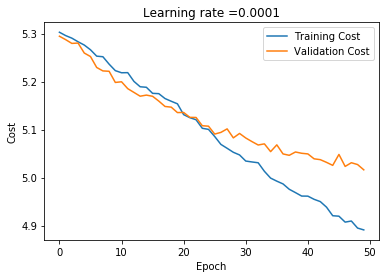

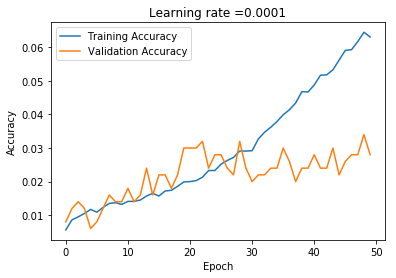

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/reid/VGG/output//vgg_model_20171116130922/saved_model.pb


In [24]:
X, Y, final_activation, keep_prob = vgg_test(parameter_dict)

cost, optimizer, predict_op, correct_prediction, accuracy = model_helpers(final_activation, Y, parameter_dict['learning_rate'])

run_model(parameter_dict, num_epochs)

In [25]:
from IPython.display import HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))
    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

In [26]:
show_graph()